## Wavelet Transform Spectrograms
### using PyWavelets: https://pywavelets.readthedocs.io/en/latest/
 - Calculations include the the spectrogram, the cross wavelet transform, the cross wavelet coherence, and the cross wavelet phase, along with the cone of influence. Could compute 95% significance contours in the future.
 - These implementations are inspired by the pycwt package: https://pycwt.readthedocs.io/en/latest/index.html and a survey of methods by Matt Hall: https://github.com/kwinkunks/timefreak.
 - Should really double check that the scaling or normalization of the power are correct, as there is a discrepancy with the STFT example.

In [1]:
import numpy as np
import scipy
from scipy import signal, ndimage
from scipy.interpolate import interp1d

import pywt

import matplotlib as mtlib
import matplotlib.pyplot as plt

from matplotlib.colors import Normalize, LogNorm, NoNorm
from matplotlib.cm import get_cmap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import transforms

import time
import os.path

import librosa

%matplotlib inline
# plt.rc('figure', figsize=(16, 4))

## Example Waveform

In [2]:
sr = 8000
_wav_file_ = "/home/riccardopasini/Documents/Aclai/Julia_additional_files/test.wav"
(wav_data, sampling_frequency) = librosa.load(_wav_file_, sr=sr, mono=True)

In [3]:
n_samples = len(wav_data)
total_duration = n_samples / sampling_frequency
sample_times = np.linspace(0, total_duration, n_samples)

sample_times indica, a che punto temporale avviene il campionamento

In [4]:
print (n_samples)
print (total_duration)
print (sample_times)

28224
3.528
[0.00000000e+00 1.25004429e-04 2.50008858e-04 ... 3.52774999e+00
 3.52787500e+00 3.52800000e+00]


## Plot the waveform:

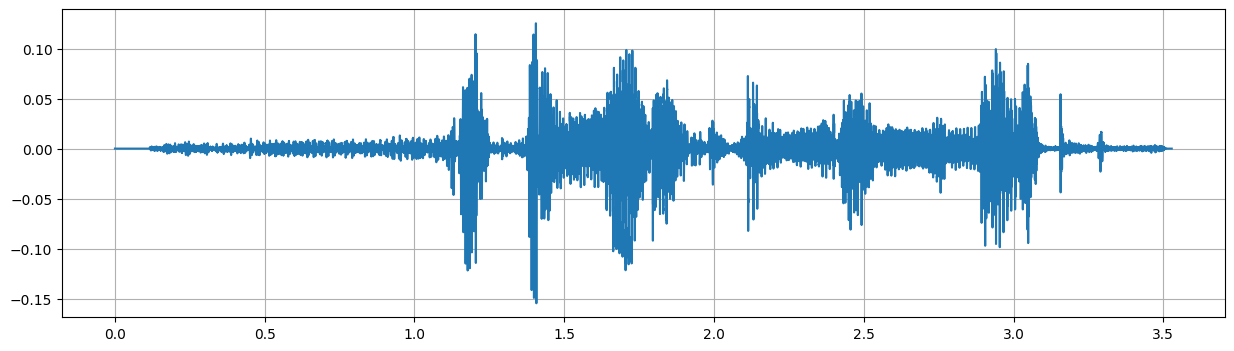

In [4]:
plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, n_samples / sampling_frequency, num=n_samples), wav_data)
plt.grid(True)

## Functions

### For comparison - the Short Time Fourier Transform Spectrogram


## What goes into a FFT spectrogram?

Other than the audio data, we need to specify several other parameters to make a spectrogram. Since a spectrogram is made by analysing the frequencies present in short segments of the audio (sometimes called "analysis frames"), we have to define how long we want those short segments to be. The first choice, then, is to specify the window length. If you're familiar with the notion of "narrowband" versus "wideband" spectrograms, window length is the parameter that underlies the difference between them: the longer the window length, the more precisely you can estimate the exact frequencies that are present within that window (and hence, the narrower the frequency bands will be; thus "narrowband" spectrograms have relatively longer window lengths). However, the whole window is analyzed as a chunk, and yields one column of values in the spectrogram, so longer windows means each column is "wider" in time, which means less precise information about when certain frequency components were loud or soft. Below, when we write a spectrogram function, we'll set our default window duration at 5 ms, which is typical for a wideband spectrogram (pretty good temporal resolution, and frequency resolution that blurs individual harmonics, making vocal tract formants easier to see), but we can always override the default by passing in a different value.

A second aspect of the window that we must specify is its shape. The shape determines how each sample within the analysis frame gets weighted (i.e., whether they are all weighted equally, or whether some get more weight than others when performing the fourier analysis). You might think that weighting all samples equally would be the best approach, but in fact that is not the case. Instead, it turns out that tapering off at the beginning and end of the window, and weighting the samples in the middle more strongly, tends to yield a more useful picture of the signal. For speech analysis, the best choice is a Gaussian window, because (unlike other window shapes) it does not result in substantial ringing ("ringing" is alternating bands of spurious energy in frequencies above and below the frequencies actually present in the signal). Here's an example of what ringing looks like: a spectrogram of a 250 Hz sine wave made with a Bartlett (triangular) window has intense horizontal stripes indicating ringing (left plot); the same signal analyzed with a Gaussian window does not.


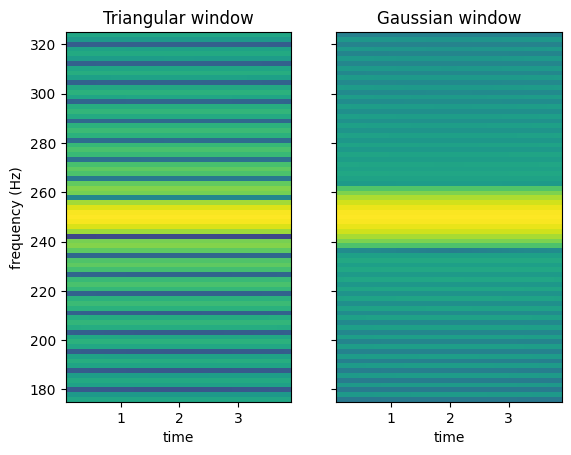

In [12]:
duration = 4
sine_frequency = 250
time = np.linspace(0, duration, 1000 * duration)
sine_wave = np.sin(2 * np.pi * sine_frequency * time)
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
kwargs = dict(x=sine_wave, Fs=1000, NFFT=256, noverlap=128, pad_to=512)
axs[0].specgram(window=np.bartlett(256), **kwargs)
axs[1].specgram(window=signal.windows.gaussian(256, int(256 / 6)), **kwargs)
axs[0].set_ylim(175, 325)
axs[0].set_ylabel('frequency (Hz)')
axs[0].set_xlabel('time')
axs[1].set_xlabel('time')
axs[0].set_title('Triangular window')
axs[1].set_title('Gaussian window');

If the signal is just a single sine wave like here, the ringing is maybe not such a big deal (we can still tell what the dominant frequency is). However, when lots of frequencies are present at different intensities (like the harmonics in a speech sound), ringing can really obscure what is going on. Since we'll pretty much always want a Gaussian window, we'll hard-code that into our custom spectrogram function; if you ever need a different window shape you can edit the function, or use the function scipy.signal.spectrogram.

Another quantity that goes into making a spectrogram is how far apart we want our analysis frames to be, a parameter called the step size. Usually, the step size is smaller than the window length, so that there is overlap between adjacent windows. Exactly how much overlap to include is a trade-off between computation time (more windows = slower computation) and how much detail we want to see. For a Gaussian window, the step size never needs to be smaller than

. Making the windows overlap any more than that only adds redundant information, unnecessarily slowing down the computation. In our function, we'll default to using that formula inside our function to make our spectrograms show as much detail as possible without doing any unnecessary computations, but we'll allow the user to pass in a different step size if they want to.

Finally, we have to decide how to map energy in a particular frequency band and time window into a particular color value. This is usually done by specifying the dynamic range, or the ratio between the quietest part that is treated as non-zero, and loudest part. For speech, there is a difference of 100 dB or more between the loudest parts of the recording and the quietest of the higher formants, so we'll set the default at 120 dB. For field recordings with a lot of background noise, you may want to set this value lower, to increase the contrast between the loud parts of the speech and the background noise.

There are two more parameters to our function we haven't yet discussed. The first is cmap which lets you specify a color mapping different than the default grayscale. The second is ax which lets you plot the spectrogram on a pre-created matplotlib.axes.Axes object (this can be handy if you want to plot the waveform and spectrogram in adjacent subplots, for example). Here's the function, with comments every few lines explaining what we're doing.

In [18]:
win_length = 0.025
step_length = 0.01
fft = 1024

In [5]:
def stft_gaussian_spectrogram(wav_data, sr, window_dur=win_length, step_dur=step_length, detrend=True, normalize=True):
# modified from: https://github.com/drammock/spectrogram-tutorial/blob/master/spectrogram.ipynb
    
    ###########################################################################
    # detrend(DC removal?) and normalize
    if detrend:
        wav_data = signal.detrend(wav_data,type='linear')
    if normalize:
        stddev = wav_data.std()
        wav_data = wav_data / stddev

    ###########################################################################
    # set default for step_dur, if unspecified. This value is optimal for Gaussian windows.
    if step_dur is None:
        step_dur = window_dur / np.sqrt(np.pi) / 8.
    
    ###########################################################################
    # convert window & step durations from seconds to numbers of samples (which is what
    # scipy.signal.spectrogram takes as input).
    window_nsamp = int(window_dur * sr * 2)
    step_nsamp = int(step_dur * sr)
    
    ###########################################################################
    # make the window. A Gaussian filter needs a minimum of 6σ - 1 samples, so working
    # backward from window_nsamp we can calculate σ.
    window_sigma = (window_nsamp + 1) / 6
    window = signal.windows.gaussian(window_nsamp, window_sigma)
    
    ###########################################################################
    # convert step size into number of overlapping samples in adjacent analysis frames
    noverlap = window_nsamp - step_nsamp
    
    ###########################################################################
    # compute the power spectral density
    freqs, times, power = signal.spectrogram(wav_data, detrend=False, mode='psd', fs=sr,
                                      scaling='spectrum', noverlap=noverlap,
                                      window=window, nperseg=window_nsamp)

    # smooth a bit
    power = ndimage.gaussian_filter(power, sigma=2)

    return power, times, freqs


### Verifica grafica dei parametri detrend e normalize (che usa la deviazione standard)

In [7]:
wav_data_det = signal.detrend(wav_data,type='linear')
stddev = wav_data.std()
wav_data_std = wav_data / stddev

Viene da pensare che detrend sia una specie di DC removal.

In [ ]:
plt.plot(sample_times, wav_data, color='r');

In [ ]:
plt.plot(sample_times, wav_data_det, color='b');

In [ ]:
plt.plot(sample_times, wav_data_std, color='g');

### Valore di step _length
Suggerito per la finestra gaussiana

In [8]:
suggested_step = win_length / np.sqrt(np.pi) / 8.
print(suggested_step)

0.0017630924485867387


### Continuous Wavelet Transform Spectrogram

In [6]:
def cwt_spectrogram(x, fs, nNotes=12, detrend=True, normalize=True):
    
    N = len(x)
    dt = 1.0 / fs
    times = np.arange(N) * dt

    ###########################################################################
    # detrend and normalize
    if detrend:
        x = signal.detrend(x,type='linear')
    if normalize:
        stddev = x.std()
        x = x / stddev

    ###########################################################################
    # Define some parameters of our wavelet analysis. 

    # maximum range of scales that makes sense
    # min = 2 ... Nyquist frequency
    # max = np.floor(N/2)

    nOctaves = int(np.log2(2*np.floor(N/2.0)))
    scales = 2**np.arange(1, nOctaves, 1.0/nNotes)
    
#     print (scales)

    ###########################################################################
    # cwt and the frequencies used. 
    # Use the complex morelet with bw=1.5 and center frequency of 1.0
    coef, freqs=pywt.cwt(x,scales,'cmor1.5-1.0')
    frequencies = pywt.scale2frequency('cmor1.5-1.0', scales) / dt
    
    ###########################################################################
    # power
#     power = np.abs(coef)**2
    power = np.abs(coef * np.conj(coef))
    
    # smooth a bit
    power = ndimage.gaussian_filter(power, sigma=2)

    ###########################################################################
    # cone of influence in frequency for cmorxx-1.0 wavelet
    f0 = 2*np.pi
    cmor_coi = 1.0 / np.sqrt(2)
    cmor_flambda = 4*np.pi / (f0 + np.sqrt(2 + f0**2))
    # cone of influence in terms of wavelength
    coi = (N / 2 - np.abs(np.arange(0, N) - (N - 1) / 2))
    coi = cmor_flambda * cmor_coi * dt * coi
    # cone of influence in terms of frequency
    coif = 1.0/coi


    return power, times, frequencies, coif

### Cross Wavelet Transform Spectrogram

In [28]:
def xwt_spectrogram(x1, x2, fs, nNotes=12, detrend=True, normalize=True):
    
    N1 = len(x1)
    N2 = len(x2)
    assert (N1 == N2),   "error: arrays not same size"
    
    N = N1
    dt = 1.0 / fs
    times = np.arange(N) * dt

    ###########################################################################
    # detrend and normalize
    if detrend:
        x1 = signal.detrend(x1,type='linear')
        x2 = signal.detrend(x2,type='linear')
    if normalize:
        stddev1 = x1.std()
        x1 = x1 / stddev1
        stddev2 = x2.std()
        x2 = x2 / stddev2

    ###########################################################################
    # Define some parameters of our wavelet analysis. 

    # maximum range of scales that makes sense
    # min = 2 ... Nyquist frequency
    # max = np.floor(N/2)

    nOctaves = int(np.log2(2*np.floor(N/2.0)))
    scales = 2**np.arange(1, nOctaves, 1.0/nNotes)

    ###########################################################################
    # cwt and the frequencies used. 
    # Use the complex morelet with bw=1.5 and center frequency of 1.0
    coef1, freqs1=pywt.cwt(x1,scales,'cmor1.5-1.0')
    coef2, freqs2=pywt.cwt(x2,scales,'cmor1.5-1.0')
    frequencies = pywt.scale2frequency('cmor1.5-1.0', scales) / dt
    
    ###########################################################################
    # Calculates the cross CWT of xs1 and xs2.
    coef12 = coef1 * np.conj(coef2)

    ###########################################################################
    # power
    power = np.abs(coef12)

    # smooth a bit
    power = ndimage.gaussian_filter(power, sigma=2)

    ###########################################################################
    # cone of influence in frequency for cmorxx-1.0 wavelet
    f0 = 2*np.pi
    cmor_coi = 1.0 / np.sqrt(2)
    cmor_flambda = 4*np.pi / (f0 + np.sqrt(2 + f0**2))
    # cone of influence in terms of wavelength
    coi = (N / 2 - np.abs(np.arange(0, N) - (N - 1) / 2))
    coi = cmor_flambda * cmor_coi * dt * coi
    # cone of influence in terms of frequency
    coif = 1.0/coi


    return power, times, frequencies, coif



### Cross Wavelet Transform Phase

In [32]:
def xwt_phase(x1, x2, fs, nNotes=12, detrend=True, normalize=True):
    
    N1 = len(x1)
    N2 = len(x2)
    assert (N1 == N2),   "error: arrays not same size"
    
    N = N1
    dt = 1.0 / fs
    times = np.arange(N) * dt

    ###########################################################################
    # detrend and normalize
    if detrend:
        x1 = signal.detrend(x1,type='linear')
        x2 = signal.detrend(x2,type='linear')
    if normalize:
        stddev1 = x1.std()
        x1 = x1 / stddev1
        stddev2 = x2.std()
        x2 = x2 / stddev2

    ###########################################################################
    # Define some parameters of our wavelet analysis. 

    # maximum range of scales that makes sense
    # min = 2 ... Nyquist frequency
    # max = np.floor(N/2)

    nOctaves = int(np.log2(2*np.floor(N/2.0)))
    scales = 2**np.arange(1, nOctaves, 1.0/nNotes)

    ###########################################################################
    # cwt and the frequencies used. 
    # Use the complex morelet with bw=1.5 and center frequency of 1.0
    coef1, freqs1=pywt.cwt(x1,scales,'cmor1.5-1.0')
    coef2, freqs2=pywt.cwt(x2,scales,'cmor1.5-1.0')
    frequencies = pywt.scale2frequency('cmor1.5-1.0', scales) / dt
    
    ###########################################################################
    # Calculate the cross transform of xs1 and xs2.
    coef12 = coef1 * np.conj(coef2)

    phase = np.angle(coef12)

    # smooth a bit
    phase = ndimage.gaussian_filter(phase, sigma=2)

    ###########################################################################
    # cone of influence in frequency for cmorxx-1.0 wavelet
    f0 = 2*np.pi
    cmor_coi = 1.0 / np.sqrt(2)
    cmor_flambda = 4*np.pi / (f0 + np.sqrt(2 + f0**2))
    # cone of influence in terms of wavelength
    coi = (N / 2 - np.abs(np.arange(0, N) - (N - 1) / 2))
    coi = cmor_flambda * cmor_coi * dt * coi
    # cone of influence in terms of frequency
    coif = 1.0/coi


    return phase, times, frequencies, coif



### Cross Wavelet Transform Coherence

In [27]:
def xwt_coherence(x1, x2, fs, nNotes=12, detrend=True, normalize=True):
    
    N1 = len(x1)
    N2 = len(x2)
    assert (N1 == N2),   "error: arrays not same size"
    
    N = N1
    dt = 1.0 / fs
    times = np.arange(N) * dt

    ###########################################################################
    # detrend and normalize
    if detrend:
        x1 = signal.detrend(x1,type='linear')
        x2 = signal.detrend(x2,type='linear')
    if normalize:
        stddev1 = x1.std()
        x1 = x1 / stddev1
        stddev2 = x2.std()
        x2 = x2 / stddev2

    ###########################################################################
    # Define some parameters of our wavelet analysis. 

    # maximum range of scales that makes sense
    # min = 2 ... Nyquist frequency
    # max = np.floor(N/2)

    nOctaves = int(np.log2(2*np.floor(N/2.0)))
    scales = 2**np.arange(1, nOctaves, 1.0/nNotes)

    ###########################################################################
    # cwt and the frequencies used. 
    # Use the complex morelet with bw=1.5 and center frequency of 1.0
    coef1, freqs1=pywt.cwt(x1,scales,'cmor1.5-1.0')
    coef2, freqs2=pywt.cwt(x2,scales,'cmor1.5-1.0')
    frequencies = pywt.scale2frequency('cmor1.5-1.0', scales) / dt
    
    ###########################################################################
    # Calculates the cross transform of xs1 and xs2.
    coef12 = coef1 * np.conj(coef2)

    ###########################################################################
    # coherence
    scaleMatrix = np.ones([1, N]) * scales[:, None]
    S1 = ndimage.gaussian_filter((np.abs(coef1)**2 / scaleMatrix), sigma=2)
    S2 = ndimage.gaussian_filter((np.abs(coef2)**2 / scaleMatrix), sigma=2)
    S12 = ndimage.gaussian_filter((np.abs(coef12 / scaleMatrix)), sigma=2)
    WCT = S12**2 / (S1 * S2)

    ###########################################################################
    # cone of influence in frequency for cmorxx-1.0 wavelet
    f0 = 2*np.pi
    cmor_coi = 1.0 / np.sqrt(2)
    cmor_flambda = 4*np.pi / (f0 + np.sqrt(2 + f0**2))
    # cone of influence in terms of wavelength
    coi = (N / 2 - np.abs(np.arange(0, N) - (N - 1) / 2))
    coi = cmor_flambda * cmor_coi * dt * coi
    # cone of influence in terms of frequency
    coif = 1.0/coi


    return WCT, times, frequencies, coif



### A Plotting Function

In [7]:
def spectrogram_plot(z, times, frequencies, coif, cmap=None, norm=Normalize(), ax=None, colorbar=True):
    ###########################################################################
    # plot
    
    # set default colormap, if none specified
    if cmap is None:
        cmap = mtlib.colormaps['Greys']
    # or if cmap is a string, get the actual object
    elif isinstance(cmap, str):
        cmap = mtlib.colormaps.get_cmap(cmap)

    # create the figure if needed
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()

    xx,yy = np.meshgrid(times,frequencies)
    ZZ = z
    
    im = ax.pcolor(xx,yy,ZZ, norm=norm, cmap=cmap)
    ax.plot(times,coif)
    ax.fill_between(times,coif, step="mid", alpha=0.4)
    
    if colorbar:
        cbaxes = inset_axes(ax, width="2%", height="90%", loc=4) 
        fig.colorbar(im,cax=cbaxes, orientation='vertical')

    ax.set_xlim(times.min(), times.max())
    ax.set_ylim(frequencies.min(), frequencies.max())

    return ax

## Test on some data

In [6]:
plt.rcParams['figure.figsize'] = (16, 6)

### STFT Spectrogram

0.00625
0.006750345230102539


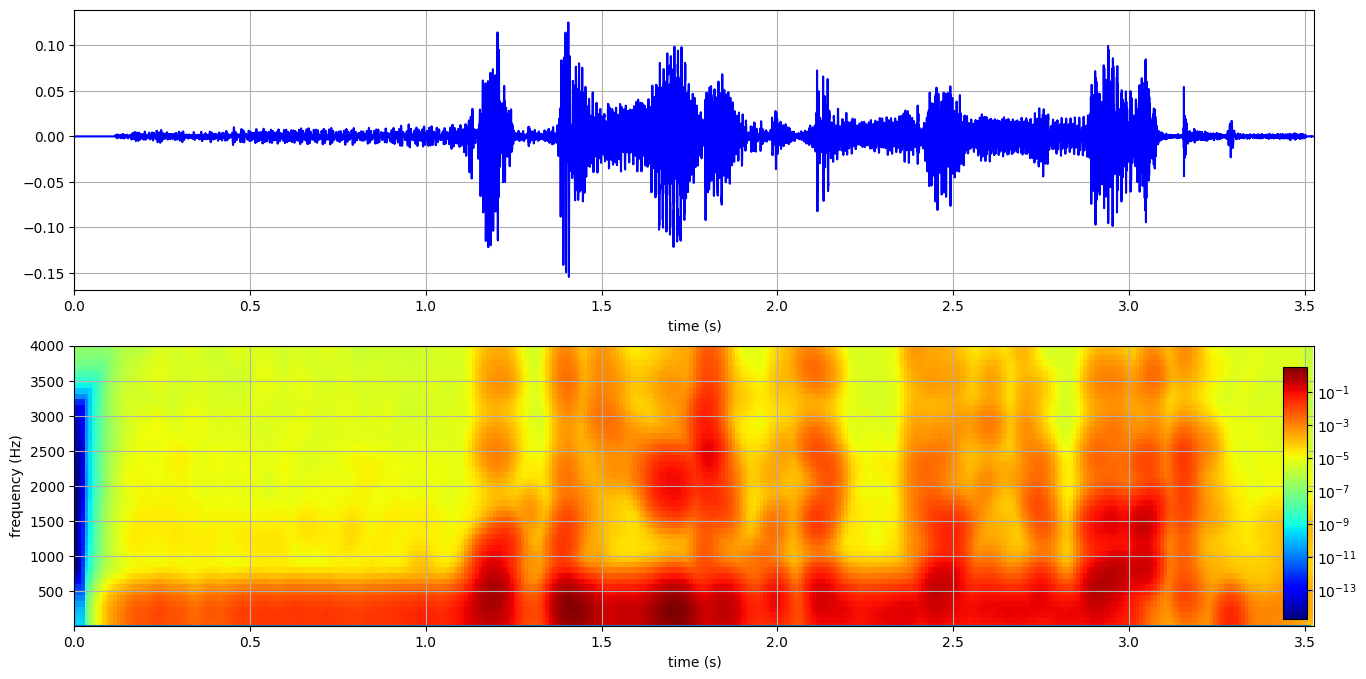

In [35]:
###########################################################################
# calculate spectrogram

wLen = 50/sampling_frequency
print(wLen)

t0 = time.time()
power, times, frequencies = stft_gaussian_spectrogram(wav_data, sampling_frequency, window_dur=wLen)
print (time.time()-t0)
coif = np.zeros(times.shape)

###########################################################################
# plot

fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(sample_times, wav_data, color='b');

ax1.set_xlim(0, total_duration)
ax1.set_xlabel('time (s)')
ax1.grid(True)

spectrogram_plot(power, times, frequencies, coif, cmap='jet', norm=LogNorm(), ax=ax2)

ax2.set_xlim(0, total_duration)
# ax2.set_ylim(0, 0.5*sampling_frequency)
ax2.set_ylim(2.0/total_duration, 0.5*sampling_frequency)
ax2.set_xlabel('time (s)')
ax2.set_ylabel('frequency (Hz)');

ax2.grid(True)

# ax2.set_yscale('log')


### Continuous Wavelet Transform

84.75897073745728


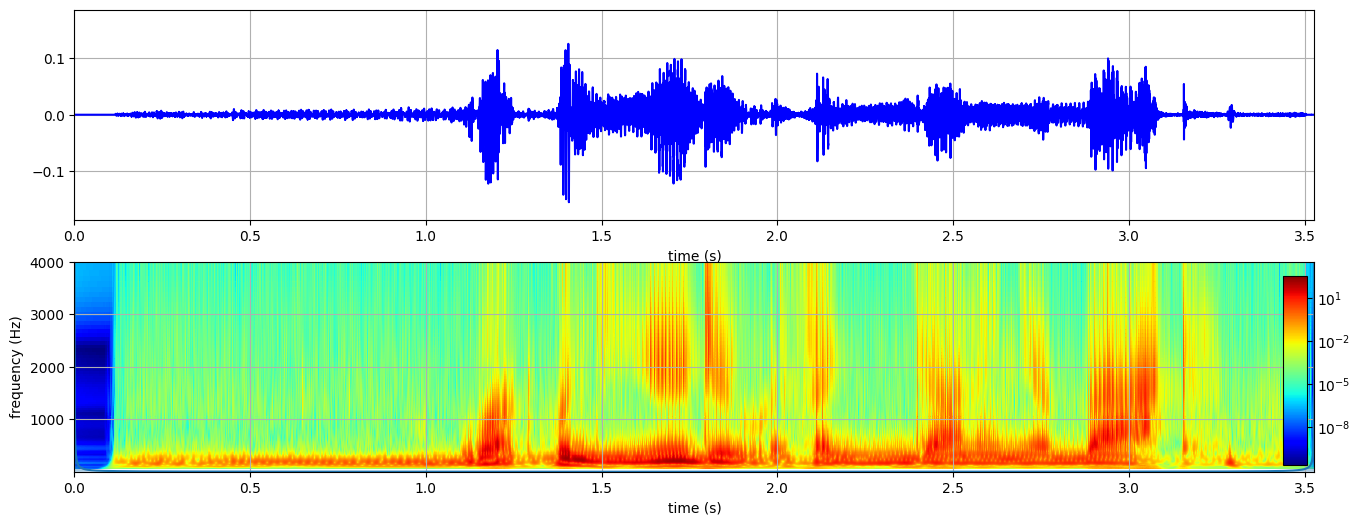

In [37]:
plt.rcParams['figure.figsize'] = (16, 6)

###########################################################################
# calculate spectrogram

t0 = time.time()
power, times, frequencies, coif = cwt_spectrogram(wav_data, sampling_frequency, nNotes=24)
print (time.time()-t0)


###########################################################################
# plot

fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(sample_times, wav_data, color='b');

ax1.set_xlim(0, total_duration)
ax1.set_xlabel('time (s)')
ax1.set_ylim(-np.abs(wav_data).max()*1.2,np.abs(wav_data).max()*1.2)
ax1.grid(True)
# ax1.axis('off')
spectrogram_plot(power, times, frequencies, coif, cmap='jet', norm=LogNorm(), ax=ax2)

ax2.set_xlim(0, total_duration)
# ax2.set_ylim(0, 0.5*sampling_frequency)
ax2.set_ylim(2.0/total_duration, 0.5*sampling_frequency)
ax2.set_xlabel('time (s)')
ax2.set_ylabel('frequency (Hz)');

ax2.grid(True)

# ax2.set_yscale('log')
# plt.savefig('wave.png')

### plot short windows and normalize to whole

In [22]:
# plt.rc('figure', figsize=(3.25, 4))

# from skimage.util import view_as_windows
# win_len = 256
# win_step = int(win_len/4)
# window_shape = (win_len,1) 

# xw = view_as_windows(wav_data.reshape(len(wav_data),1),window_shape,step=win_step).squeeze()
# tw = view_as_windows(sample_times.reshape(len(sample_times),1),window_shape,step=win_step).squeeze()

# # xw = xw/wav_data.std()

# print(xw.shape)

# idx = 12

# ###########################################################################

# # calculate spectrogram

# ### need to input start time or whole time vector

# t0 = time.time()
# power, times, frequencies, coif = cwt_spectrogram(xw[idx]/wav_data.std(), sampling_frequency, nNotes=24, normalize=False)
# print (time.time()-t0)


# ###########################################################################
# # plot

# fig, (ax1, ax2) = plt.subplots(2, 1)
# # x = wav_data[idx]
# # t = sample_times[idx]

# ax1.plot(tw[idx], xw[idx], color='b');

# # ax1.set_xlim(0, total_duration)
# ax1.set_xlim(tw[idx].min(), tw[idx].max())
# ax1.set_ylim(-np.abs(wav_data).max()*1.2,np.abs(wav_data).max()*1.2)
# ax1.set_xlabel('time (s)')
# ax1.grid(True)

# vmin=1.0e-6
# vmax=100

# spectrogram_plot(power, times+tw[idx].min(), frequencies, coif, cmap='jet', norm=LogNorm(vmin, vmax), ax=ax2, colorbar=False)
# # spectrogram_plot(power, times, frequencies, coif, cmap='jet', norm=LogNorm(), ax=ax2)

# # ax2.set_xlim(times.min(), times.max())
# # ax2.set_ylim(0, 0.5*sampling_frequency)
# # ax2.set_ylim(2.0/total_duration, 0.5*sampling_frequency)
# ax2.set_xlim(tw[idx].min(), tw[idx].max())
# ax2.set_xlabel('time (s)')# plt.rc('figure', figsize=(16, 4))
# ax2.set_ylabel('frequency (Hz)');

# ax2.grid(True)
# ax1.xaxis.set_visible(False)
# ax1.yaxis.set_visible(False)
# ax2.xaxis.set_visible(False)
# ax2.yaxis.set_visible(False)
# # fig.axes(False)
# # ax2.set_yscale('log')
# plt.savefig('win12.png')

### Practice changing the x-axis units and interpolating

65.51986575126648


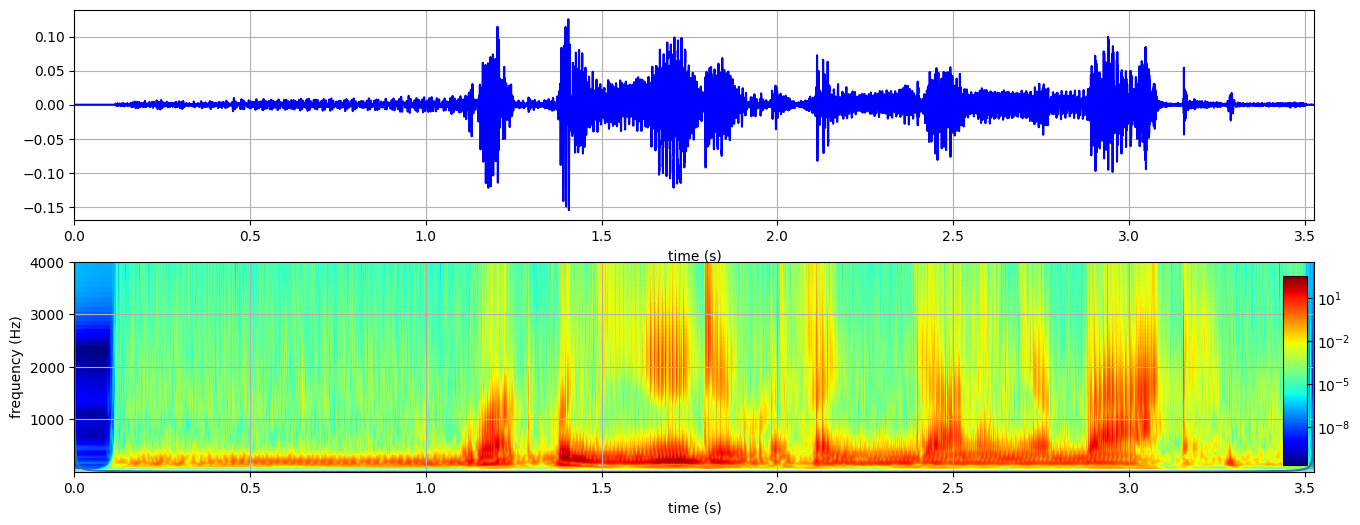

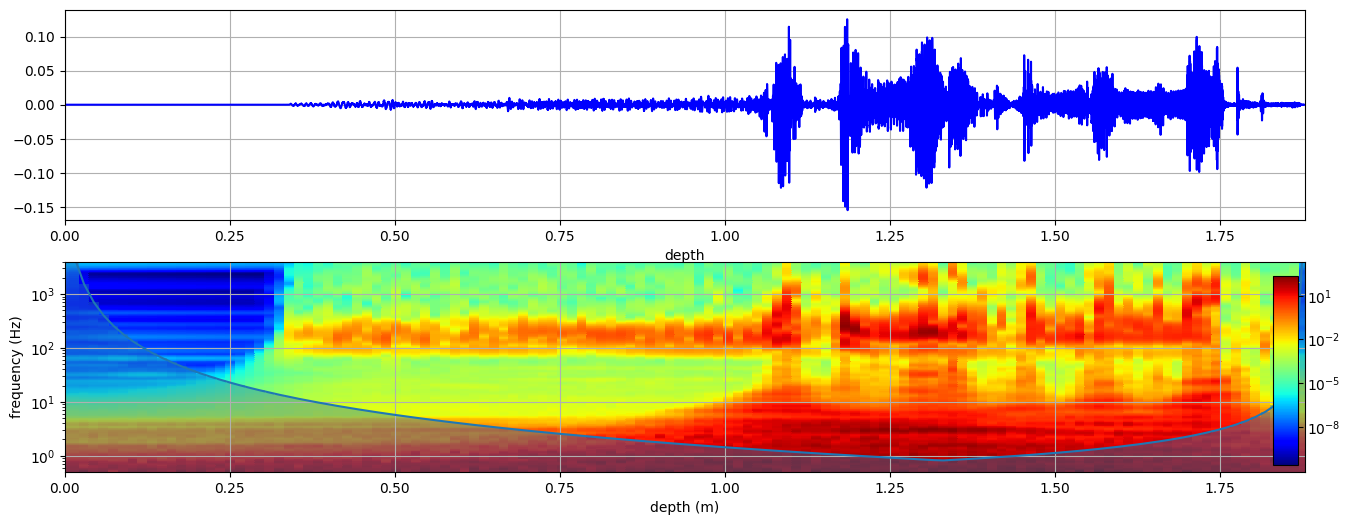

In [23]:
###########################################################################
# calculate spectrogram

t0 = time.time()
power, times, frequencies, coif = cwt_spectrogram(wav_data, sampling_frequency, nNotes=24)
print (time.time()-t0)


###########################################################################
# plot

fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(sample_times, wav_data, color='b');

ax1.set_xlim(0, total_duration)
ax1.set_xlabel('time (s)')

ax1.grid(True)

spectrogram_plot(power, times, frequencies, coif, cmap='jet', norm=LogNorm(), ax=ax2)

ax2.set_xlim(0, total_duration)
# ax.set_ylim(0, 0.5*sampling_frequency)
# ax2.set_ylim(2.0/total_duration, 0.5*sampling_frequency)
ax2.set_xlabel('time (s)')
ax2.set_ylabel('frequency (Hz)');

ax2.grid(True)

# ax2.set_yscale('log')


###########################################################################
# plot spectrogram again but ...
# change x axis to new units and interpolate spectrum to match on equally spaced grid
###########################################################################

# fig, (ax2) = plt.subplots(1, 1)
fig, (ax1, ax2) = plt.subplots(2, 1)

depths = np.sqrt(times)

t2d = interp1d(times,depths,kind='cubic')
d2t = interp1d(depths,times,kind='cubic')

nFreq = len(frequencies)
nNew = 128
lindepths = np.linspace(depths.min(),depths.max(),nNew)
times2 = d2t(lindepths)

ZZ = np.zeros((nFreq,nNew))
for i in range(nFreq):
    fZZi = interp1d(times,power[i,:],kind='cubic')
    ZZ[i,:] = fZZi(times2)
fcoif = interp1d(times,coif,kind='cubic')
coif2 = fcoif(times2)

# ZZ = ndimage.gaussian_filter(ZZ, sigma=2)

ax1.plot(depths, wav_data, color='b');

ax1.set_xlim(0, depths.max())
ax1.set_xlabel('depth')

ax1.grid(True)

spectrogram_plot(ZZ, lindepths, frequencies, coif2, cmap='jet', norm=LogNorm(), ax=ax2)

ax2.grid(True)
ax2.set_yscale('log')
ax2.set_xlabel('depth (m)')
ax2.set_ylabel('frequency (Hz)');

### Cross Wavelet Transform

In [24]:
plt.rcParams['figure.figsize'] = (16, 8)

In [25]:
# make some bad data to compre to

noise = np.random.randn(len(wav_data))*wav_data.max()/100
bad_data = np.copy(wav_data)
# bad_data = np.roll(bad_data,0)
bad_data[500:700] = np.roll(bad_data[500:700],100)

bad_data[200:300] = bad_data[200:300]+noise[200:300]/5
bad_data[900:] = bad_data[900:]+noise[900:]

130.2261083126068


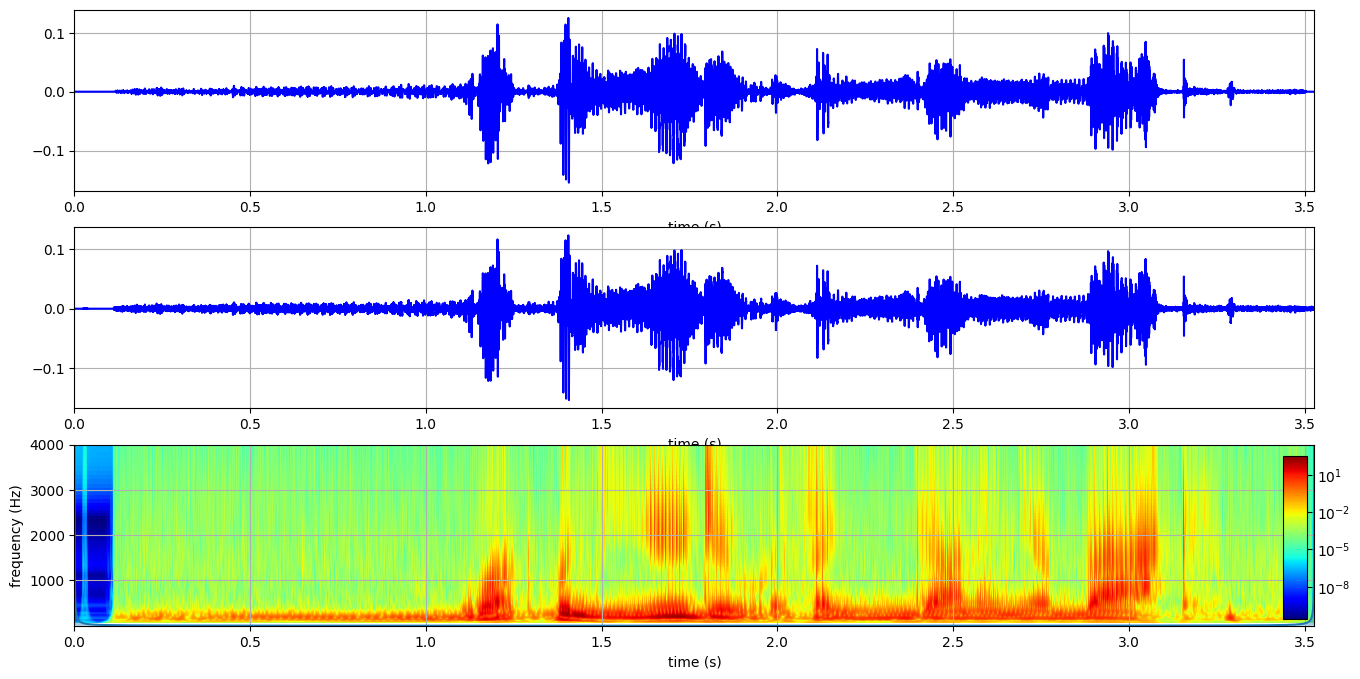

In [29]:
###########################################################################
# calculate spectrogram

t0 = time.time()
power, times, frequencies, coif = xwt_spectrogram(wav_data, bad_data, sampling_frequency, nNotes=24)
print (time.time()-t0)


################################################################
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

################################################################
ax1.plot(sample_times, wav_data, color='b');

ax1.set_xlim(0, total_duration)
ax1.set_xlabel('time (s)')

ax1.grid(True)
################################################################
ax2.plot(sample_times, bad_data, color='b');

ax2.set_xlim(0, total_duration)
ax2.set_xlabel('time (s)')

ax2.grid(True)
################################################################

spectrogram_plot(power, times, frequencies, coif, cmap='jet', norm=LogNorm(), ax=ax3)
ax3.set_xlim(0, total_duration)
# ax.set_ylim(0, 0.5*sampling_frequency)
ax3.set_ylim(2.0/total_duration, 0.5*sampling_frequency)
ax3.set_xlabel('time (s)')
ax3.set_ylabel('frequency (Hz)');

ax3.grid(True)
# ax3.set_yscale('log')

### Cross Wavelet Coherence

136.70934438705444


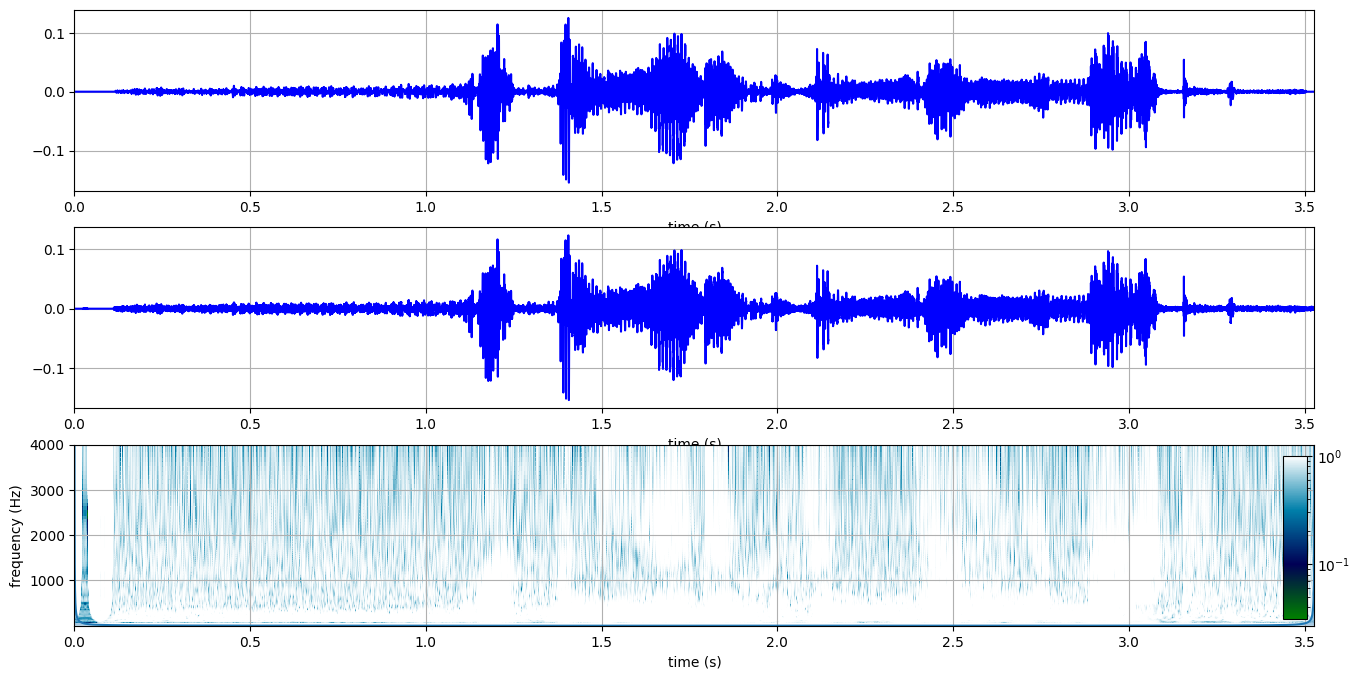

In [30]:
###########################################################################
# calculate spectrogram

t0 = time.time()
coherence, times, frequencies, coif = xwt_coherence(wav_data, bad_data, sampling_frequency, nNotes=24)
print (time.time()-t0)


################################################################
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

################################################################
ax1.plot(sample_times, wav_data, color='b');

ax1.set_xlim(0, total_duration)
ax1.set_xlabel('time (s)')

ax1.grid(True)
################################################################
ax2.plot(sample_times, bad_data, color='b');

ax2.set_xlim(0, total_duration)
ax2.set_xlabel('time (s)')

ax2.grid(True)
################################################################

spectrogram_plot(coherence, times, frequencies, coif, cmap='ocean', norm=LogNorm(), ax=ax3)
ax3.set_xlim(0, total_duration)
# ax.set_ylim(0, 0.5*sampling_frequency)
ax3.set_ylim(2.0/total_duration, 0.5*sampling_frequency)
ax3.set_xlabel('time (s)')
ax3.set_ylabel('frequency (Hz)');

ax3.grid(True)
# ax3.set_yscale('log')

### Cross Wavelet Phase

173.48547291755676


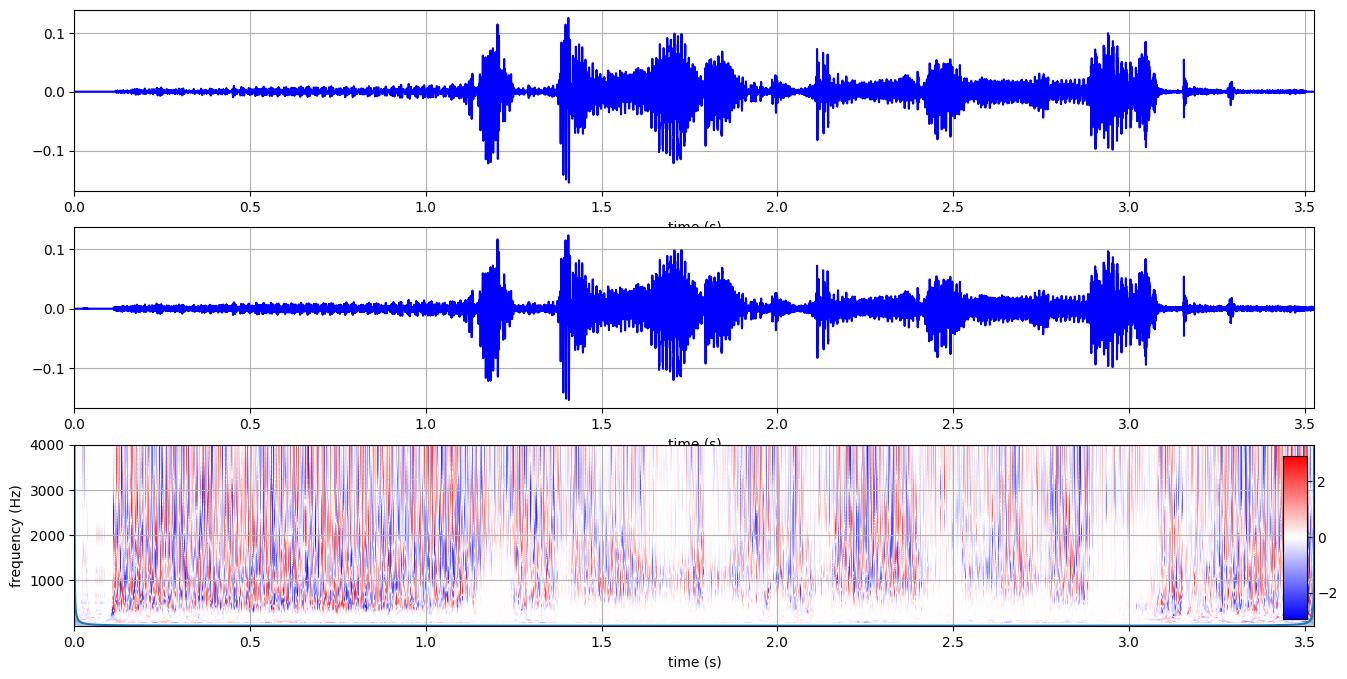

In [33]:
###########################################################################
# calculate spectrogram

t0 = time.time()
phase, times, frequencies, coif = xwt_phase(wav_data, bad_data, sampling_frequency, nNotes=24)
print (time.time()-t0)


################################################################
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

ax1.plot(sample_times, wav_data, color='b');

ax1.set_xlim(0, total_duration)
ax1.set_xlabel('time (s)')

ax1.grid(True)


ax2.plot(sample_times, bad_data, color='b');

ax2.set_xlim(0, total_duration)
ax2.set_xlabel('time (s)')

ax2.grid(True)
################################################################

spectrogram_plot(phase, times, frequencies, coif, cmap='bwr', norm=Normalize(), ax=ax3)
ax3.set_xlim(0, total_duration)
# ax.set_ylim(0, 0.5*sampling_frequency)
ax3.set_ylim(2.0/total_duration, 0.5*sampling_frequency)
ax3.set_xlabel('time (s)')
ax3.set_ylabel('frequency (Hz)');

ax3.grid(True)
# ax3.set_yscale('log')

# Wavelet to Mfcc

### analisi preparativa fft e continous wavelet

In [17]:
stft, stft_times, stft_freq = stft_gaussian_spectrogram(wav_data, sampling_frequency)
print("fft")
print (len(stft), "vettori, di lunghezza:", len(stft[1]))

cwt, cwt_times, cwt_freq, coif = cwt_spectrogram(wav_data, sampling_frequency, nNotes=24)
print("cwt")
print (len(cwt), "vettori, di lunghezza:", len(cwt[1]))

fft
201 vettori, di lunghezza: 348
cwt
312 vettori, di lunghezza: 28224
